This is a notebook following the "Deep learning Workshop for Satellite Imagery - Data Processing" tutorial found on YouTube by Dr. Avkash Chauhan. Please see their Github page (https://github.com/prodramp/DeepWorks/tree/main/DL-SatelliteImagery) for the tutorial, code, and info.

It uses Dubai dataset with Segmentation images, downloaded from Kaggle (https://www.kaggle.com/datasets/humansintheloop/semantic-segmentation-of-aerial-imagery). Humans in the Loop are the owners of the data (https://humansintheloop.org/resources/datasets/semantic-segmentation-dataset-2/)

In [124]:
import os
import cv2
from PIL import Image 
import numpy as np 
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from matplotlib import pyplot as plt
import random

In [125]:
minmaxscaler = MinMaxScaler() #This needs to be at the top for some reason. I am not sure why, to be honest. It initially worked if you called it right before you used it?

In [126]:
#Set the root directory for this project
dataset_root_folder = "C:/Users/chanc/Documents/RemoteSensing/MBRSC_Dubai_samples"

#Name your dataset
dataset_name = "SemanticSegmentationDataset"


OSwalk helps us select a folder and returns the paths of subdirectories and files. Use the next code chucnk to specify the type of image to confirm what you're using (i.e. images or masks)


In [127]:
for path, subdirs, files in os.walk(dataset_root_folder):
    dir_name = path.split(os.path.sep)[-1]
    print(dir_name)
    if dir_name == 'images':
        images = os.listdir(path)
        #print(images)
        for i, image_name in enumerate(images):
            print(image_name)
        

C:/Users/chanc/Documents/RemoteSensing/MBRSC_Dubai_samples
SemanticSegmentationDataset
Tile 1
images
image_part_001.jpg
image_part_002.jpg
image_part_003.jpg
image_part_004.jpg
image_part_005.jpg
image_part_006.jpg
image_part_007.jpg
image_part_008.jpg
image_part_009.jpg
masks
Tile 2
images
image_part_001.jpg
image_part_002.jpg
image_part_003.jpg
image_part_004.jpg
image_part_005.jpg
image_part_006.jpg
image_part_007.jpg
image_part_008.jpg
image_part_009.jpg
masks
Tile 3
images
image_part_001.jpg
image_part_002.jpg
image_part_003.jpg
image_part_004.jpg
image_part_005.jpg
image_part_006.jpg
image_part_007.jpg
image_part_008.jpg
image_part_009.jpg
masks
Tile 4
images
image_part_001.jpg
image_part_002.jpg
image_part_003.jpg
image_part_004.jpg
image_part_005.jpg
image_part_006.jpg
image_part_007.jpg
image_part_008.jpg
image_part_009.jpg
masks
Tile 5
images
image_part_001.jpg
image_part_002.jpg
image_part_003.jpg
image_part_004.jpg
image_part_005.jpg
image_part_006.jpg
image_part_007.jpg
im

Next, can use OpenCV to read the data in the image. 

In [128]:
#Use cv2 in opencv to read the data in the image
image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile 1/images/image_part_001.jpg',1)
#image
image.shape #get height, width, and color type (e.g. RGB, greyscale)

(644, 797, 3)

Next, you can get the image type once it's read in.

In [129]:
print(type(image))


<class 'numpy.ndarray'>


We need to convert the image type from numpy.ndarray to the correct image type.

In [130]:
type(Image.fromarray(image))

PIL.Image.Image

However, not all our images are in the same shape (they have different dimensions, seen below). Currently, each tile has different dimensions. We need to make sure everything is the same shape before we can begin.

In [131]:
image_dataset = [] #create an array since the imageset is divided into diff tiles. Iterate and create tile_id for each tile to make this easier
image_extension = 'jpg' #since we want the jpg images right now
for tile_id in range(1,8):
    for image_id in range(1,20):
        image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/images/image_part_00{image_id}.{image_extension}', 1)  #imread returns RGB order, but ours is in BGR data. Remember this
        if image is not None:
            print(image.shape)

(644, 797, 3)
(644, 797, 3)
(644, 797, 3)
(643, 797, 3)
(643, 797, 3)
(643, 797, 3)
(644, 797, 3)
(644, 797, 3)
(644, 797, 3)
(544, 509, 3)
(544, 510, 3)
(544, 509, 3)
(544, 509, 3)
(544, 510, 3)
(544, 509, 3)
(544, 509, 3)
(544, 510, 3)
(544, 509, 3)
(658, 682, 3)
(658, 682, 3)
(658, 682, 3)
(658, 682, 3)
(658, 682, 3)
(658, 682, 3)
(658, 682, 3)
(658, 682, 3)
(658, 682, 3)
(846, 1099, 3)
(846, 1099, 3)
(846, 1099, 3)
(846, 1099, 3)
(846, 1099, 3)
(846, 1099, 3)
(846, 1099, 3)
(846, 1099, 3)
(846, 1099, 3)
(1058, 1126, 3)


(1058, 1126, 3)
(1058, 1126, 3)
(1058, 1126, 3)
(1058, 1126, 3)
(1058, 1126, 3)
(1058, 1126, 3)
(1058, 1126, 3)
(1058, 1126, 3)
(838, 859, 3)
(838, 859, 3)
(838, 859, 3)
(838, 859, 3)
(838, 859, 3)
(838, 859, 3)
(838, 859, 3)
(838, 859, 3)
(838, 859, 3)
(2061, 1817, 3)
(2061, 1816, 3)
(2061, 1817, 3)
(2062, 1817, 3)
(2062, 1816, 3)
(2062, 1817, 3)
(2061, 1817, 3)
(2061, 1816, 3)
(2061, 1817, 3)


### Tile and Mask processing
1. Decide the patch size for our images (i.e. 256x256 or 512x512)
2. Make sure all the tiles and mask images size are multiples of the patch size
3. Split all the images into the patch size and convert it into numpy array

In [132]:
#Define image patch size
image_patch_size = 256

#Get image shape again, use Tile 2 this time.
image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile 2/images/image_part_001.jpg',1)
image.shape
#If image size is 544x509, this doesn't match up with the 256, so we need to mod it with our patch size
(image.shape[0]//image_patch_size)*image_patch_size

512

In [133]:
### Issue with MinMaxScaler here. Idk why it won't work here (it did on the initial runtrhough of the tutorial, but doesn't now), but works fine later.

#Here is an example of how to convert every pixel to a value between 0 and 1 using the MinMaxScaler library

#image_patches = patchify(image, (image_patch_size, image_patch_size, 3), step = image_patch_size)
#image_patches
#
#
#image_x = image_patches[0,0,:,:]
#image_y = minmaxscaler.fit_transfrom(image_x.reshape(-1, image_x.shape[-1])).reshape(image_x.shape)

In [134]:
image_dataset = [] #create an array since the imageset is divided into diff tiles. Iterate and create tile_id for each tile to make this easier\
mask_dataset = []

for image_type in ['images' , 'masks']:
  if image_type == 'images':
    image_extension = 'jpg'
  elif image_type == 'masks':
     image_extension = 'png'
  for tile_id in range(1,8):
    for image_id in range(1,20):
      image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}',1)
      if image is not None:
        if image_type == 'masks':
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #This line makes sure you're converting the BGR color to RGB, which we need.
        #print(image.shape)
        size_x = (image.shape[1]//image_patch_size)*image_patch_size
        size_y = (image.shape[0]//image_patch_size)*image_patch_size
        #print("{} --- {} - {}".format(image.shape, size_x, size_y))
        image = Image.fromarray(image)
        image = image.crop((0,0, size_x, size_y))
        #print("({},  {})".format(image.size[0],image.size[1]))

        #To apply patch, need to convert image back to np arry
        image = np.array(image)
        patched_images = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)
        #print(len(patched_images))
        for i in range(patched_images.shape[0]):
          for j in range(patched_images.shape[1]):
            if image_type == 'images':
              individual_patched_image = patched_images[i,j,:,:]
              #print(individual_patched_image.shape)
              individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
              individual_patched_image = individual_patched_image[0]
              #print(individual_patched_image.shape)
              image_dataset.append(individual_patched_image)
            elif image_type == 'masks':
              individual_patched_mask = patched_images[i,j,:,:]
              individual_patched_mask = individual_patched_mask[0]
              mask_dataset.append(individual_patched_mask)

image_dataset = np.array(image_dataset) #convert the datasets in numpy arrays
mask_dataset = np.array(mask_dataset)


In [135]:
#Check length of datasets to confirm they match, then check to make sure they're in arrays that match
print(len(image_dataset))
print(len(mask_dataset))
image_dataset
mask_dataset

945
945


array([[[[132,  41, 246],
         [132,  41, 246],
         [132,  41, 246],
         ...,
         [132,  41, 246],
         [132,  41, 246],
         [132,  41, 246]],

        [[132,  41, 246],
         [132,  41, 246],
         [132,  41, 246],
         ...,
         [132,  41, 246],
         [132,  41, 246],
         [132,  41, 246]],

        [[132,  41, 246],
         [132,  41, 246],
         [132,  41, 246],
         ...,
         [132,  41, 246],
         [132,  41, 246],
         [132,  41, 246]],

        ...,

        [[132,  41, 246],
         [132,  41, 246],
         [132,  41, 246],
         ...,
         [132,  41, 246],
         [132,  41, 246],
         [132,  41, 246]],

        [[132,  41, 246],
         [132,  41, 246],
         [132,  41, 246],
         ...,
         [132,  41, 246],
         [132,  41, 246],
         [132,  41, 246]],

        [[132,  41, 246],
         [132,  41, 246],
         [132,  41, 246],
         ...,
         [132,  41, 246],
        

Output is decimal values because we used the MinMaxScaler to convert to values between 0 and 1

Let's display the first image from the image_dataset

numpy.ndarray

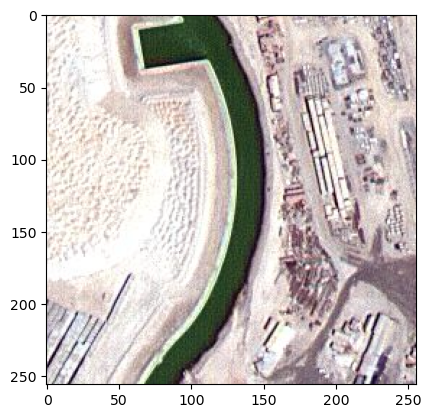

In [136]:
plt.imshow(image_dataset[0])
type(image_dataset[0]) #confirming it is a numpy array


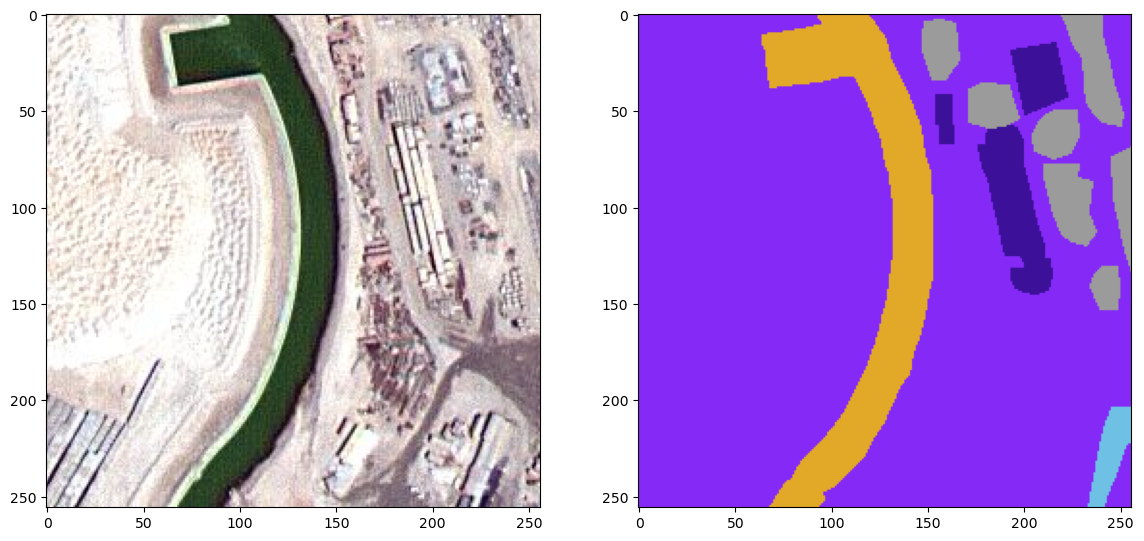

In [137]:
#Let's show the image and mask side by side to compare.
plt.figure(figsize = (14,8))
plt.subplot(121) #Needs to be 3 numbers to specify nrows, ncols, and index
plt.imshow(image_dataset[0])
plt.subplot(122)
plt.imshow(mask_dataset[0])

You can even check random images and masks by assigning an image id to each image or mask in the dataset and call that instead of specifying the index. The following code will return the image and mask of a random image each time you run it.

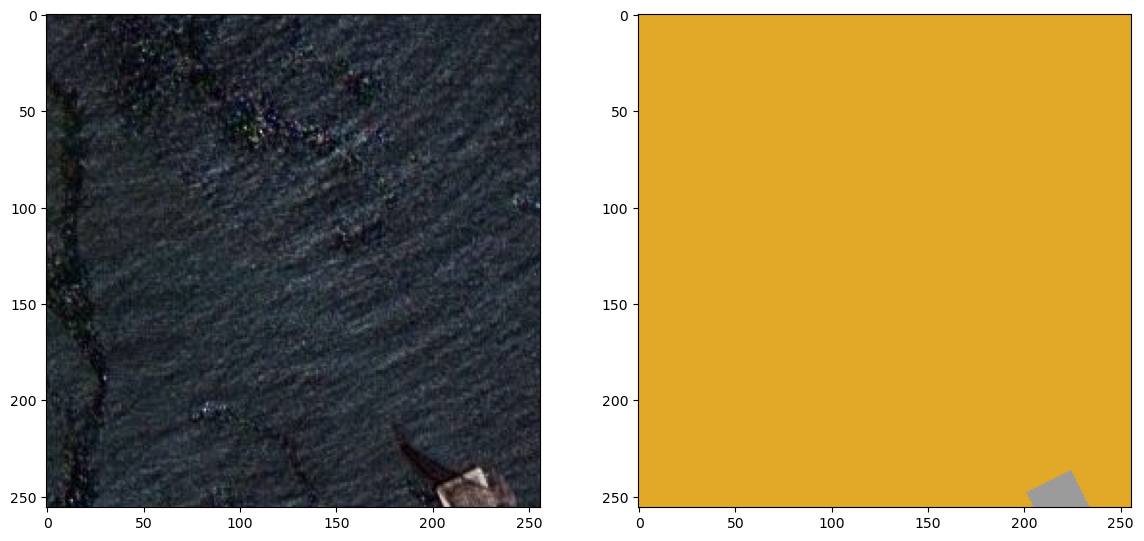

In [138]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize = (14,8))
plt.subplot(121) 
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])

### Processing Mask Labels

Looking at the json files or data card on Kaggle, we can find the labels for the masks, including buildings, land, road, vegetation, water, and unlabeled areas.

In [139]:
class_building = '#3c1098' #Get the value from the data card. Store as string. Remove the hash sign, though, using the next function
class_building = class_building.lstrip('#')

#We also need to split the initial value into 3 segments (e.g. 3c1098 into 3C 10 98). Generate a tuple. 16 is the base for hexadecimal
tuple(int(class_building[i:i+2], 16) for i in (0,2,4))

#Now convert to np array
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))


In [140]:
#repeat the process for the other classes
class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))

class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))

class_water = '#E2A929'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))


Now we need to take the RGB value and conver to a 2D label

In [141]:
mask_dataset.shape

(945, 256, 256, 3)

In [142]:
#We want to do this to our individual patched masks
#label = individual_patched_mask
#
#def rgb_to_label(label):
#    label_segment = np.zeros(label.shape, dtype = np.uint8) #creating empty array same size as the labels dataset so we can fill it
#    print(label_segment.shape)
#    label_segment = 1
#    return label_segment

In [143]:
#So there's 945 images in shape 256, 256, 3
#labels = []
#for i in range(mask_dataset.shape[0]):
#    label = rgb_to_label(mask_dataset[i])
#    labels.append(label)


In [144]:
##check length to confirm
#len(labels)
#
##turn into numpy array
#labels = np.array(labels)
#
#labels[0]

##### Now let's take a look at the label coding. 

Looking at the info in classes.json file, we see that water = 0, land = 1, road = 2, building = 3, vegetation = 4, and unlabeled = 5. 

In [145]:
#We want to do this to our individual patched masks
label = individual_patched_mask


def rgb_to_label(label):
  label_segment = np.zeros(label.shape, dtype=np.uint8)  #creating empty array same size as the labels dataset so we can fill it
  label_segment[np.all(label == class_water, axis=-1)] = 0
  label_segment[np.all(label == class_land, axis=-1)] = 1
  label_segment[np.all(label == class_road, axis=-1)] = 2
  label_segment[np.all(label == class_building, axis=-1)] = 3
  label_segment[np.all(label == class_vegetation, axis=-1)] = 4
  label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
  #print(label_segment)
  label_segment = label_segment[:,:,0] #Take only one value, so use the :,:,0 notation
  print(label_segment)
  return label_segment
     






In [146]:
labels = []
for i in range(mask_dataset.shape[0]):
  label = rgb_to_label(mask_dataset[i])
  labels.append(label)
     

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
[[1 5 5 ... 0 0 0]
 [1 5 5 ... 0 0 0]
 [1 1 5 ... 0 0 0]
 ...
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]]
[[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
[[1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
[[2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]
[[1 1 1 ... 3 3 3]
 [1 1 1 ... 3 3 3]
 [1 1 1 ... 3 3 3]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
[[1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
[[2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [

In [147]:
labels = np.array(labels)



In [148]:
labels[3]

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

In [149]:
labels = np.expand_dims(labels, axis = 3)

In [150]:
labels[0]

array([[[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       ...,

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]]], dtype=uint8)

In [151]:
np.unique(labels)

print("Total unique labels based on masks:", format(np.unique(labels)))

Total unique labels based on masks: [0 1 2 3 4 5]


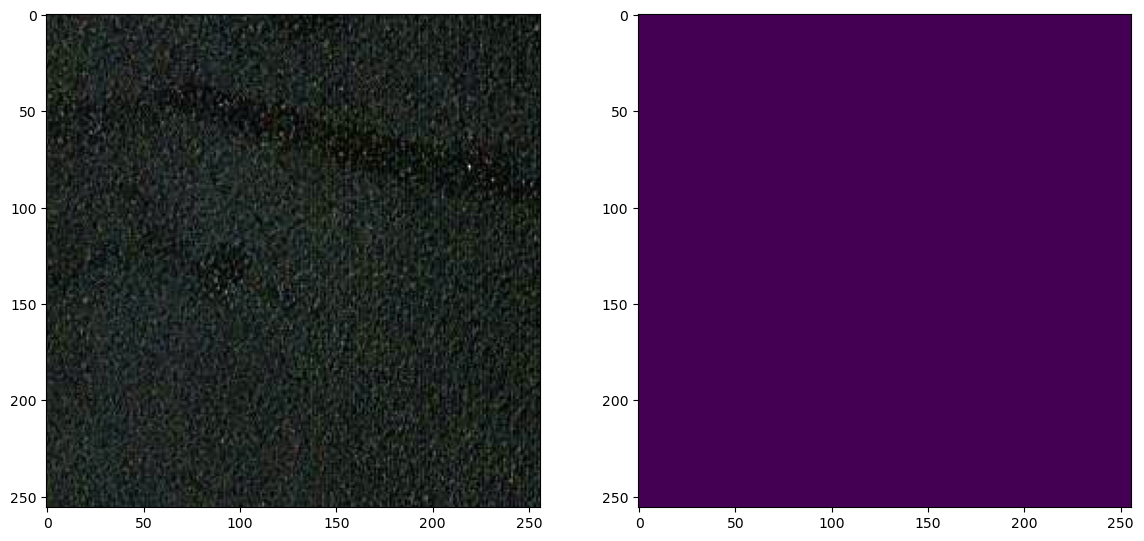

In [152]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize = (14,8))
plt.subplot(121) 
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
#plt.imshow(mask_dataset[random_image_id])
plt.imshow(labels[random_image_id][:,:,0])

In [153]:
labels[0][:,:,0] #This slices the data, shows you what values are in that firat mask

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

### Creating Training and Test Dataset

In [154]:
total_classes = len(np.unique(labels)) #How many unique classes we have (we know this though, this just confirms we've still got them)
total_classes

6

In [155]:
from tensorflow.keras.utils import to_categorical

In [156]:
labels_categorical_dataset = to_categorical(labels, num_classes=total_classes, ) #process labels dataset as y, need to provide the total # of classes, and can provide the data type if you need to.

In [157]:
labels_categorical_dataset

array([[[[0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         ...,
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         ...,
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         ...,
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.]],

        ...,

        [[0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         ...,
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0.

In [158]:
labels_categorical_dataset.shape

(945, 256, 256, 6)

In [159]:
master_training_dataset = image_dataset


In [160]:
master_training_dataset.shape

(945, 256, 256, 3)

In [161]:
from sklearn.model_selection import train_test_split

In [162]:
x_train, x_test, y_train, y_test = train_test_split(master_training_dataset, labels_categorical_dataset, test_size= 0.15, random_state=100) #needs input dataset and corresponding labels dataset, and dataset shapes must match.

In [163]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(803, 256, 256, 3)
(142, 256, 256, 3)
(803, 256, 256, 6)
(142, 256, 256, 6)


In [164]:
image_height = x_train.shape[1] #Just checking things to make sure they still match up with what we wanted. Can do the same for the Y, too.
image_width = x_train.shape[2]
image_channels = x_train.shape[3]

print(image_height)
print(image_width)
print(image_channels)

256
256
3


### Now we move on to training and prediction (Part 2 of 3 in the workshop videos)

In [165]:
from keras.models import Model 
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda

In [166]:
from keras import backend as K  #Backend will be tensorflow, but you can tell it to use a different deep learning library if you want

Evaluation Metrics: Jaccard Index / Intersection over Union (IOU). It's the overlap divided by the union of the data. Basically dividing what the two datasets (training and test) have in common over the entire master dataset. This is called the Jaccard Index. We will apply this to our labels data.

If the overlap in your data is the exact same as the union in the dataset, your IOU will be = 1. If the overlap is not a perfect match, you'll get a much lower value. Getting over 90% overlap is a great result.

In [167]:
def jaccard_coef(y_true, y_pred):
    y_true_flatten = K.flatten(y_true) #need to flatten y_true 
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    final_coef_value = intersection +1.0 / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0) #Jaccard index coefficient
    return final_coef_value

We'll be using the U-net: Convolutional Networks for Biomedical Image Segmentation model from here https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/ where you can find the model architecture. We will also be using Netron app to visualize (any) deep learning model: https://netron.app

The image below is the U-net model architecture.

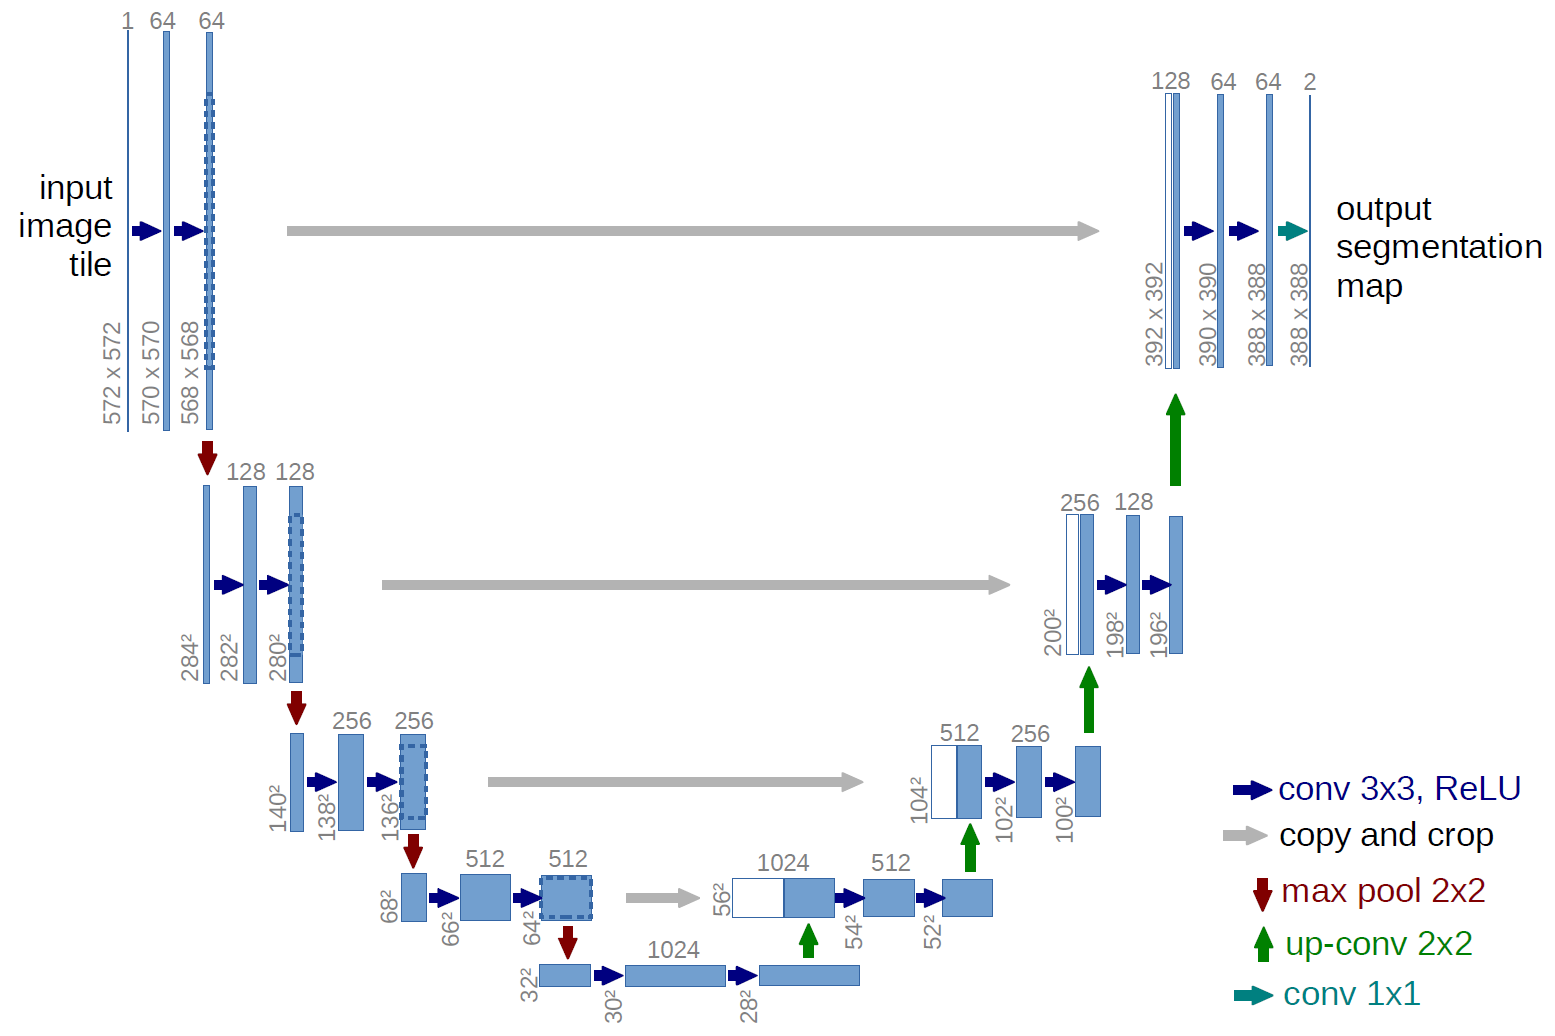

In [168]:
from IPython.display import Image
Image(filename="C:/Users/chanc/Documents/RemoteSensing/Unet_architecture.png")

Creation of the U-net model

In [169]:
def multi_unet_model(n_classes = 5, image_height = 256, image_width = 256, image_channels = 1):   #default values

    inputs = Input((image_height, image_width, image_channels))

    source_input = inputs
    
    c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input) #first convolutional 2d layer. See the architecture diagram on U-net website linked above to see that the convolution is 3x3 and activation is ReLU
    c1 = Dropout(0.2)(c1) #as a rate, so this drops 20% of the values. So we created a convolutional layer, passed the input (c1), then take the 20% dropout off, then the remainder is the new c1 with 80% of original points left. You can experiment with different values and see how it affects your model
    c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1) # you need to do 2 convolution layers according to the model arch, so do the exact same convolution as the first time. 
    p1 = MaxPooling2D((2,2))(c1) #again, you may need to adjust and validate the 2,2 values based on your dataset

    c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1) #32 for 2nd convolution layer instead of 16 because we need to double it for max pooling step
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2) #64 because you double it again. Check the arch diagram to see when you double
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
    p3 = MaxPooling2D((2,2))(c3)

    c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3) 
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
    p4 = MaxPooling2D((2,2))(c4)

    c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4) 
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)
    #No max pooling this time! Only 4x

    u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding= "same")(c5) #moving on to up-conversion or up-sampling  
    u6 = concatenate([u6, c4]) #copy and crop step
    c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

    u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding= "same")(c6)    
    u7 = concatenate([u7, c3]) #moving back up now, so c4 to c3
    c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

    u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding= "same")(c7)    
    u8 = concatenate([u8, c2]) 
    c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

    u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding= "same")(c8)    
    u9 = concatenate([u9, c1], axis = 3) #the default axis is -1, but since we don't need any further concatenation, we'll perform concat on the axis 3
    c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

    #output layer is the final convolution
    outputs = Conv2D(n_classes, (1,1), activation = "softmax")(c9)
  

    model = Model(inputs =[inputs],outputs =[outputs])
    return model

In [170]:
metrics = ["accuracy", jaccard_coef]

In [171]:
def get_deep_learning_model():
    return multi_unet_model(n_classes = total_classes, 
                            image_height = image_height, 
                            image_width = image_width, 
                            image_channels = image_channels)

In [172]:
model = get_deep_learning_model() #if you get an error, go back and reduce the number of layers by commenting out many of the later layers and creating a temporary output layer with the new, reduced layer (c3 or whatever) instead of c9 or whatevr your last layer ends up being


## Calling it a night at 42:47 on part 2, ending Aug 17, 2023. Pick up at: Defining custom Loss Function